# Running Facebook Prophet model for forecasting SSB data from API

Facebook has just open sourced [`Prophet`](https://facebookincubator.github.io/prophet/), a forecasting project available in `Python`.

At its core, the `Prophet` procedure is an **additive regression model** with four main components (based on [`Stan`](http://mc-stan.org) Bayesian approach):
1. a piecewise linear (or logistic) growth curve trend: `Prophet` automatically detects changes in trends by selecting changepoints from the data,
2. a yearly seasonal component modeled using Fourier series,
3. a weekly seasonal component using dummy variables,
4. a user-provided list of important holidays.

We wikl (**blindly: we make no assumption whatsoever here**, beyond the obvious seasonality of the data) use the features 1. and 2. of the model to **build forecast estimates of Statistics Norway monthly CPI [*tour_occ_nim*](https://data.ssb.no/api/v0/dataset/1086?lang=no) **:

<img src="">

We suppose here that all required packages have been already install (see `Prophet` original webpage for `Prophet`'s dependencies). Let us first import everything we need:

In [1]:
import pandas as pd
import numpy as np
# needed for display in notebook:
#%matplotlib notebook 
from matplotlib import pyplot as plt
import APIdata as apid

import warnings
warnings.filterwarnings('ignore')

## Testing datasets from API:

In [2]:
ckk = apid.API_to_data(language='no')
ckk.search('makro*')

,table_title,score,published
table_id,,,
11721,Makroøkonomiske hovedstørrelser. Ujustert og ...,0.866025,2018-09-11T08:00:00
09190,Makroøkonomiske hovedstørrelser. Ujustert og ...,0.866025,2018-08-23T08:00:00
09189,Makroøkonomiske hovedstørrelser 1970 - 2017,0.866025,2018-08-23T08:00:00


In [3]:
ckk = apid.API_to_data(language='no')
tablenr = '09190'   #måned eksempel: 11721, uke eksempel: 03024, kvartal eksempel: 09190
box_info = ckk.select(tablenr)
box_info

Info is saved


In [4]:
[df, label] = ckk.read_box(box_info)
df

,makrostørrelse,statistikkvariabel,kvartal,value
0,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1978K1,288553
1,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1978K2,297876
2,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1978K3,298582
3,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1978K4,312749
4,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1979K1,304271
5,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1979K2,294970
6,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1979K3,315293
7,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1979K4,335598
8,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1980K1,335169
9,"Bruttonasjonalprodukt, markedsverdi",Faste 2016-priser (mill. kr),1980K2,321009


In [5]:
time_column = 'kvartal' #måned, uke, kvartal eller år
value_column = 'value'

In [6]:
df = ckk.prepare_dataframe(time_col=time_column, val_col=value_column, df=df)
df.head()

,ds,y
0,1978-01-01,288553
1,1978-02-01,297876
2,1978-03-01,298582
3,1978-04-01,312749
4,1979-01-01,304271


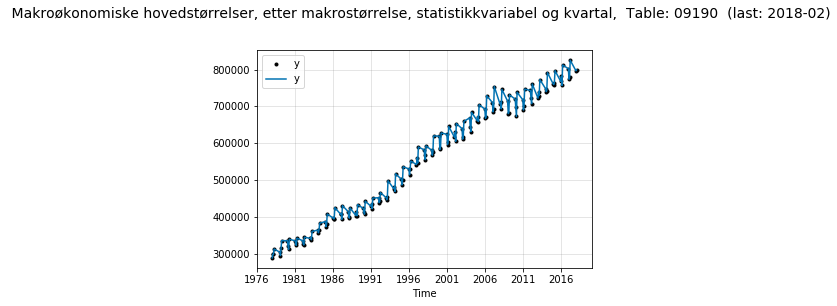

In [7]:
df.sort_values('ds', inplace=True)
ds_last = df['ds'].values[-1].astype('datetime64[M]')
xlabel = "Time"
ylabel = "Value"  
plt.plot(df['ds'], df['y'], 'k.')
plt.plot(df['ds'], df['y'], ls='-', c='#0072B2')
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel(xlabel, fontsize=10); #plt.ylabel(ylabel, fontsize=10)
plt.suptitle(" {},  Table: {}  (last: {})".format(label, tablenr, ds_last), fontsize=14, y=1.03)
plt.legend()
plt.show()

In [8]:
from fbprophet import Prophet
nyears=5
m = Prophet(growth = 'linear', weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=4*nyears, freq='q')
fcst = m.predict(future)

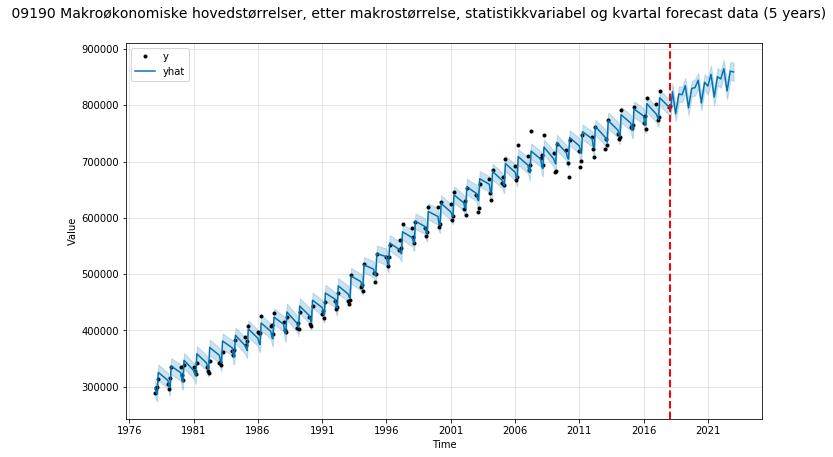

In [9]:
ds_last = df['ds'].values[-1]
m.plot(fcst, uncertainty=True)
xlabel = "Time"
ylabel = "Value" 
plt.axvline(pd.to_datetime(ds_last), color='r', linestyle='--', lw=2)
plt.xlabel(xlabel, fontsize=10); plt.ylabel(ylabel, fontsize=10)
plt.suptitle(" {} {} forecast data ({} years)".format(tablenr, label, nyears), fontsize=14, y=1.05)
plt.legend()
plt.show()

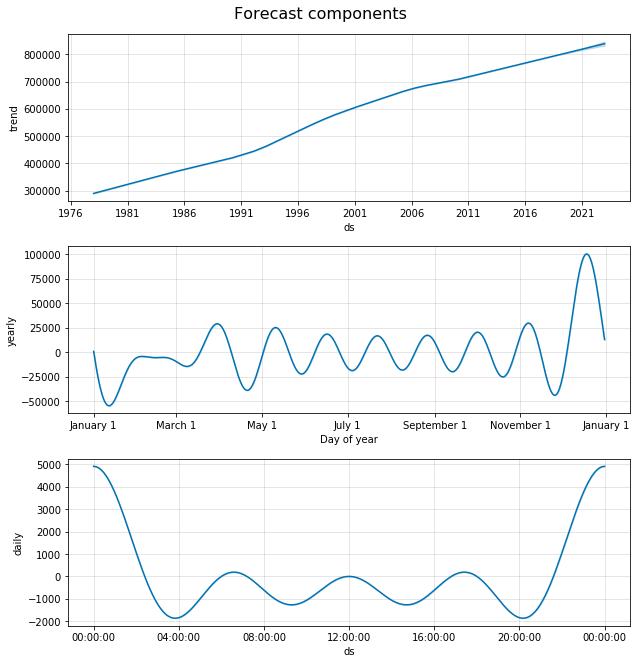

In [10]:
fig = m.plot_components(fcst, uncertainty=True)
fig.suptitle("Forecast components", fontsize=16, y=1.02)
plt.show()

In [12]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
174,2021-03-31,854804.808186,840007.592295,870923.150580
175,2021-06-30,814656.484544,799115.004804,828504.870439
176,2021-09-30,850799.139635,835422.778169,866223.281356
177,2021-12-31,846624.195833,831133.134938,861841.419419
178,2022-03-31,865067.857937,850616.336345,880470.939294
179,2022-06-30,825343.272533,810508.673507,840943.339339
180,2022-09-30,860666.994414,845987.327056,877410.515452
181,2022-12-31,859221.444986,843064.515335,875667.037219


In [ ]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("S:/faglig/it/test/hack4ssb/profeten/knr.csv", sep = ';', decimal = ',')

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

If you copy paste this URL in your browser as is, you can display the data as they are returned by the REST service, in [`jsonstat`](https://json-stat.org) format:


Next, we want to store the data in a `pandas.DataFrame` object (since the input to `Prophet` is always a `pandas.DataFrame`). From here, it should be possible to perform this operation using any of  [`pyjstat`](https://pypi.python.org/pypi/pyjstat/) or [`jsonstat.py`](https://github.com/26fe/jsonstat.py) dedicated packages, _e.g._:
```python
collection = jsonstat.from_url(url)
tour_occ_nim = collection.dataset('tour_occ_nim')
df = tour_occ_nim.to_data_frame('year')
```


Once we have retrieved the response, we further extract/format the data of interest from the formatted `jsonstat` dictionary:

The table contains exactly the data we need, let us store it into a `pandas.DataFrame` object as desired. As already mentioned, the input to `Prophet` is always a `pandas.DataFrame` object, and it must contain two columns: `ds` and `y`. 

df = pd.DataFrame(list(table.items()), columns=['ds','y'])
 df = df[df['y'].notnull()] # Prophet can deal with NaN data!

We also sort the data "chronogically" (this is not really neede since the sorting is also done in `Prophet`, but it will be useful for plotting):

Considering the trend observed in the data, we define the regression model for `Prophet` by instantiating a new `Prophet` model as follows:

We then call its `fit` method and pass in the historical dataframe built earlier:

We extend the data into the future by a specified number of days using the `make_future_dataframe` method. Say that we consider to predict the time-series over the 5 next years:

Let us plot the forecast estimates calculated by the `Prophet` model:

`Prophet` also provides with the components (overall trend and yearly profile) of the time-series: